In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

In [2]:
# For inline plots in Jupyter Notebook
%matplotlib inline

In [3]:
# Load & Clean Data
df = pd.read_csv("D2.csv")
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df.dropna(subset=['posts', 'status'], inplace=True)
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
print("Data shape after cleaning:", df.shape)
print(df['status'].value_counts())


Data shape after cleaning: (10391, 3)
status
neutral          4374
negative         4112
very negative    1155
positive          750
Name: count, dtype: int64


In [4]:
# Balance Classes by Resampling
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("After resampling:")
print(df['status'].value_counts())

After resampling:
status
negative         4374
neutral          4374
positive         4374
very negative    4374
Name: count, dtype: int64


In [5]:
# Encode Labels
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2,
    'very negative': 3,
}
df['status_label'] = df['status'].map(label_map)

In [6]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

input_ids = np.zeros((len(df), MAX_LEN), dtype='int32')
attention_masks = np.zeros((len(df), MAX_LEN), dtype='int32')

def generate_bert_inputs(df, input_ids, attention_masks, tokenizer):
    for i, text in tqdm.tqdm(enumerate(df['posts']), total=len(df)):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='np'
        )
        input_ids[i, :] = tokenized['input_ids']
        attention_masks[i, :] = tokenized['attention_mask']
    return input_ids, attention_masks

input_ids, attention_masks = generate_bert_inputs(df, input_ids, attention_masks, tokenizer)


100%|██████████| 17496/17496 [01:11<00:00, 245.28it/s]


In [7]:
#One-Hot Labels & tf.data
num_classes = 4
labels = np.zeros((len(df), num_classes), dtype='int32')
labels[np.arange(len(df)), df['status_label'].values] = 1

dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))
def to_dict(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
dataset = dataset.map(to_dict)
dataset = dataset.shuffle(10000, seed=42).batch(32, drop_remainder=True)

In [8]:
#Train/Val/Test Split
def split_train_val_test(ds, train_frac=0.8, val_frac=0.1, test_frac=0.1):
    ds = ds.shuffle(10000, seed=42)
    n = len(list(ds))
    n_train = int(train_frac * n)
    n_val = int(val_frac * n)
    train_ds = ds.take(n_train)
    val_ds = ds.skip(n_train).take(n_val)
    test_ds = ds.skip(n_train + n_val)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_train_val_test(dataset)


In [9]:
# Model Definition & Training
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

in_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype='int32', name='input_ids')
in_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype='int32', name='attention_mask')

sequence_output = bert_model(in_ids, attention_mask=in_mask).last_hidden_state
x = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)
)(sequence_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=[in_ids, in_mask], outputs=out)
model.summary()

optim = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
model.compile(optimizer=optim,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'hybrid_bert_bilstm.keras', monitor='val_loss',
    save_best_only=True, mode='min', verbose=1)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlystop_cb, checkpoint_cb]
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

C:\Users\TOH KAI KIAN\Documents\anaconda\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


436/436 [==============================] - 4527s 10s/step - loss: 0.7968 - accuracy: 0.6968 - val_loss: 0.4207 - val_accuracy: 0.8501
Epoch 2/10
436/436 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8646
Epoch 2: val_loss improved from 0.42066 to 0.22344, saving model to hybrid_bert_bilstm.keras
436/436 [==============================] - 4254s 10s/step - loss: 0.4042 - accuracy: 0.8646 - val_loss: 0.2234 - val_accuracy: 0.9300
Epoch 3/10
436/436 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9164
Epoch 3: val_loss improved from 0.22344 to 0.17281, saving model to hybrid_bert_bilstm.keras
436/436 [==============================] - 4245s 10s/step - loss: 0.2655 - accuracy: 0.9164 - val_loss: 0.1728 - val_accuracy: 0.9491
Epoch 4/10
436/436 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9486
Epoch 4: val_loss improved from 0.17281 to 0.09167, saving model to hybrid_bert_bilstm.keras
436/436 [======================

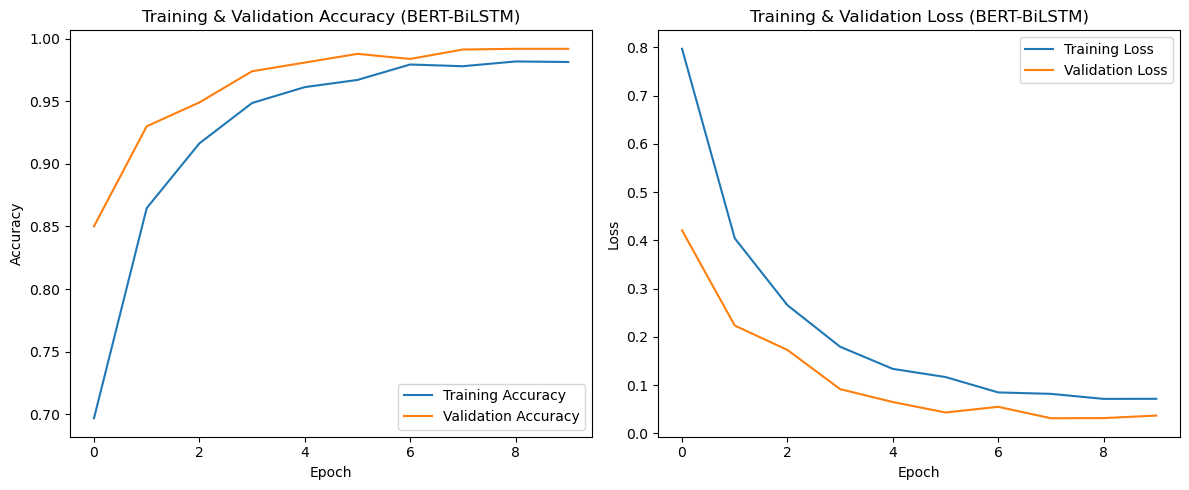

In [16]:
# Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (BERT-BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (BERT-BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [21]:
# Load Best Model
from transformers import TFBertModel
model = tf.keras.models.load_model(
    'hybrid_bert_bilstm.keras',
    custom_objects={'TFBertModel': TFBertModel},
    compile=True
)


C:\Users\TOH KAI KIAN\Documents\anaconda\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Test loss and accuracy:
Loss: 0.0437
Accuracy: 0.9916 (99.16%)
1/1 [==============================] - 4s 4s/step

Classification Report:
               precision    recall  f1-score   support

     negative     0.9822    0.9977    0.9899       443
      neutral     1.0000    0.9832    0.9915       477
     positive     0.9977    0.9977    0.9977       429
very negative     0.9955    0.9977    0.9966       443

     accuracy                         0.9939      1792
    macro avg     0.9938    0.9941    0.9939      1792
 weighted avg     0.9939    0.9939    0.9939      1792



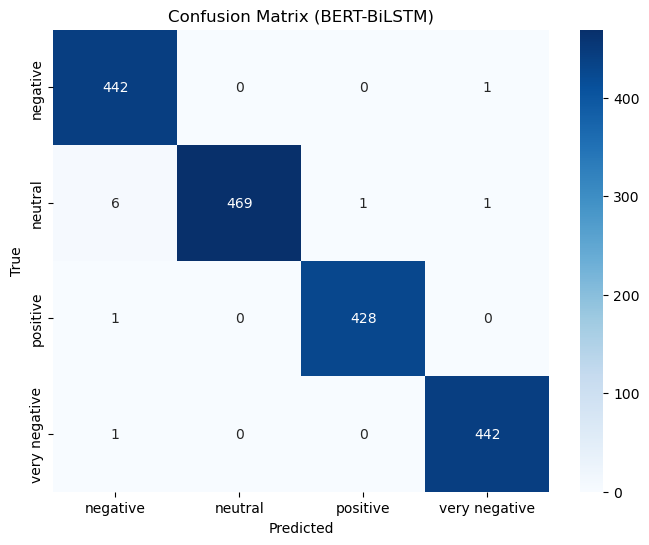

In [22]:
# Evaluation 
print("\nTest loss and accuracy:")
loss, accuracy = model.evaluate(test_ds, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

statuses = ['negative', 'neutral', 'positive', 'very negative']
y_true, y_pred, y_pred_probs = [], [], []
for batch in test_ds:
    inputs, labels_onehot = batch
    probs = model.predict(inputs)
    preds = np.argmax(probs, axis=1)
    truths = np.argmax(labels_onehot.numpy(), axis=1)
    y_pred_probs.extend(probs)
    y_pred.extend(preds)
    y_true.extend(truths)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.vstack(y_pred_probs)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=statuses, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=statuses, yticklabels=statuses)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (BERT-BiLSTM)')
plt.show()

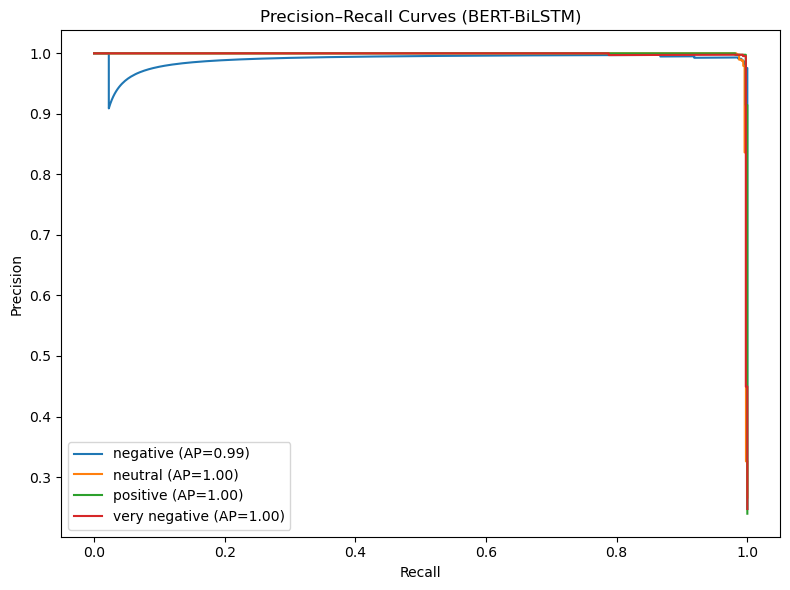

In [23]:
# Binarize for multi-class curves
n_classes = len(statuses)
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# Precision-Recall Curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(statuses):
    prec, rec, _ = precision_recall_curve(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    ap = average_precision_score(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    plt.plot(rec, prec, label=f'{cls} (AP={ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves (BERT-BiLSTM)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


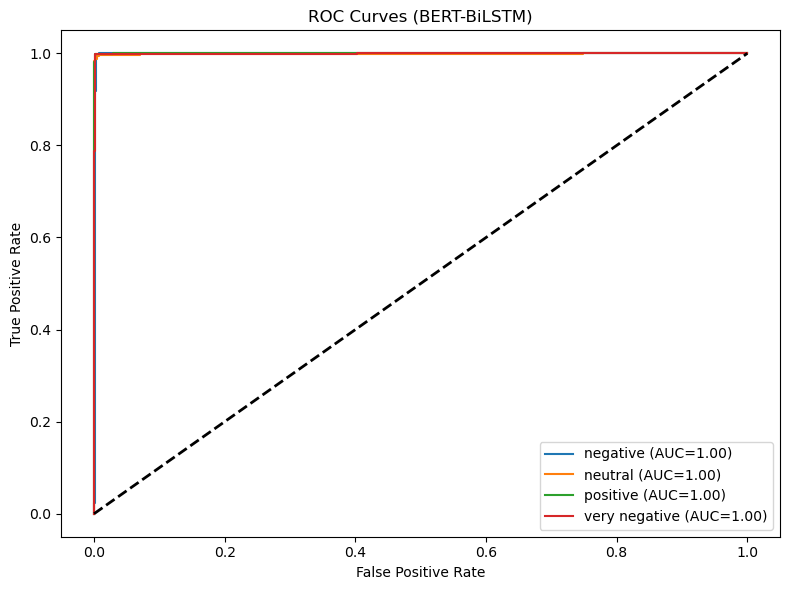

In [24]:
# ROC Curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(statuses):
    fpr, tpr, _ = roc_curve(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (BERT-BiLSTM)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
